# Project Epidemic Model

**MDI230 - Files d'attente**

S2-P4 2022/23

* MONTES, Julia Soledad.
* PARAFATI, Mauro.
* PONS, Bruno.

### Imports

In [146]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import statistics 

### Deterministic system SIR



The population, $N$  is divided into three categories:

- $S(t)$ : susceptible to be infected
- $I(t)$ : infected 
- $R(t)$ : recovered from the disease with immunity


The $SIR$ model, depends on $\beta$ and $\gamma$ parameters, where:

- $\beta > 0 $ is the rate of contraction of the disease (transmission parameter)
- $\gamma > 0 $ is the mean recovery rate


The model is based on the following assumptions:

- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time
- The rate of infected individuals leaving compartment I is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N = S+I+R$ is constant.

The system of equations of the model is given by:

$$\left\lbrace\begin{array}{c} \frac{dS}{dt} = -\frac{\beta S}{N}I - \gamma I \\
\frac{dI}{dt} = \frac{\beta S}{N}I -\gamma I \\
\frac{dR}{dt} = \gamma I
\end{array}\right.$$

These equations describe the rate of change of each compartment over time. The first equation represents the change in the susceptible population, which decreases as individuals become infected. The second equation represents the change in the infected population, which increases due to new infections and decreases as individuals recover. The third equation represents the change in the recovered population, which increases as individuals recover from the disease.

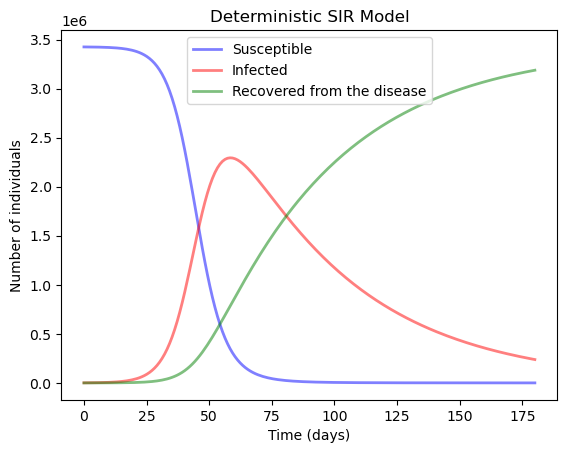

In [147]:
# Differential equations for the SIR model
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Plot function for S(t), I(t), R(t)
def plot(S, I, R, t, divide_by=1, title=''):
    fig, ax = plt.subplots()
    ax.plot(t, np.array(S) / divide_by, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, np.array(I) / divide_by, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, np.array(R) / divide_by, 'g', alpha=0.5, lw=2, label='Recovered from the disease')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel(f'Number of individuals')
    ax.set_title(title)
    legend = ax.legend()
    
# Initial conditions
N = 3426_000 # Initial population (we consider the population of Uruguay)
I0 = 1_000 # Number of initial infected
R0 = 0 # Number of initial recovered individuals
S0 = N - I0 - R0 # Number of initial susceptible individuals

# Infection and recovery rates
beta = 0.2 # Infection rate
gamma = 0.02 # Recovery rate

# A grid of time points (in days)
t = np.linspace(0, 180, 180)

# Initial conditions vector
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t
ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plots
plot(S, I, R, t, title='Deterministic SIR Model') # Data without normalization
#plot(S, I, R, t, divide_by=N, title='SIR Model - Data with normalization') # Data normalized



### Markov process for a population of N individuals.



In the Markovian model, we redefine the parameter $\beta$, which now represents the encounter rate with susceptibles, infected, and retired individuals (including the deceased). Assuming that the duration of infection $I$ follows an exponential distribution with a mean of $1/\gamma$, the process $X = (S, I, R)$ becomes a Markov process. It exhibits the following transitions:

\begin{align*}
(S, I, R) &\rightarrow (S - 1, I + 1, R) \quad \text{at rate} \quad \beta N^{-1}IS \mathbf{1}_{\{s>0\}} \\
&\rightarrow (S, I - 1, R + 1) \quad \text{at rate} \quad \gamma I \mathbf{1}_{\{i>0\}}
\end{align*}

Here, the rate of new infection attempts is $\beta I$, and each infected individual has a probability of $S/N$ to encounter a susceptible. Therefore, the rate of new infections is $\beta\frac{IS}{N}$ if the number of susceptibles is not zero.

Each infected individual transitions out of this state at a rate of $\gamma$. Thus, the rate of exiting for at least one infected individual is $\gamma I$. 


In [148]:
# Markovian model
def Markovian_SIR(N, beta, gamma, t_max):
    # Initial conditions
    I = 1000
    R = 0
    S = N - I - R

    # Initialize time and state variables
    t = 0
    S_data = [S]
    I_data = [I]
    R_data = [R]

    # Main simulation loop
    while t < t_max:
        # Calculate rates of infection and recovery
        rate_infection = beta * I * S / N
        rate_recovery = gamma * I

        # Calculate total rate
        total_rate = rate_infection + rate_recovery

        # Generate two random numbers for Poisson processes
        r1, r2 = np.random.random(size=2)

        # Calculate time to the next event
        dt = -np.log(r1) / total_rate

        # Determine which event (infection or recovery) occurs
        if r2 < rate_infection / total_rate:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

        # Update time
        t += dt

        # Append current state to data lists
        S_data.append(S)
        I_data.append(I)
        R_data.append(R)

    return S_data, I_data, R_data

t_max = 180

# Run simulation
S_data, I_data, R_data = Markovian_SIR(N, beta, gamma, t_max)

# Plot results
t = np.linspace(0, t_max, len(S_data))
plot(S_data, I_data, R_data, t, divide_by=1, title='Markovian SIR Model')



### Find pairs of values ($ \beta, \gamma$)

- Everyone is removed in the long term:

Deterministic: In this case, we are looking for parameter values that lead to the eventual elimination of the disease from the population, where everyone transitions to the removed ($R$) compartment. This can occur when the infection rate ($\beta$) is sufficiently low, indicating a low rate of new infections, and the recovery rate ($gamma$) is high enough to quickly remove individuals from the infected ($I$) compartment.

- There is a portion of the population that remains susceptible, and another portion is removed:

Deterministic: In this scenario, we are looking for parameter values that result in a stable equilibrium where a fraction of the population remains susceptible while another fraction is removed (recovered). This implies that the disease persists in the population, but not everyone gets infected. The values of beta and gamma need to strike a balance between the infection rate and the recovery rate to achieve this partial equilibrium.

In [ ]:
#code to find the beta and gamma

### Illustrate graphically the convergence of the renormalised Markov process towards the solution of the deterministic system

### Parameter estimation from French public health data

Using data from Santé Publique France, which has 4 columns: hospitalisations (hos), admissions to intensive care (rea), deaths (dc) and people sent home (rad) for each day and for each département, how would you go about estimating gamma and beta for a given department?

In [ ]:
db = pd.read_csv('covid-hospit-incid-2023-03-31-18h01.csv', sep=';')

In [ ]:
display(db)

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,01,2020-03-19,1,0,0,0
1,01,2020-03-20,0,0,0,1
2,01,2020-03-21,3,0,0,0
3,01,2020-03-22,3,1,0,1
4,01,2020-03-23,14,1,0,5
...,...,...,...,...,...,...
113011,978,2023-03-27,0,0,0,0
113012,978,2023-03-28,0,0,0,0
113013,978,2023-03-29,0,0,0,0
113014,978,2023-03-30,0,0,0,0
